HW 5
USCID: 9166932624
Name: Qifan Chen

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from IPython.display import display
from scipy.stats import bootstrap
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

Time Series Classification Part 1: Feature Creation/Extraction

（b）Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
actions = ["bending1", "bending2", "cycling",
"lying", "sitting", "standing", "walking","test"]
# Floder names in alphabetical order of first letter

data_list = [] # store all of data frames
test_index = [] # store test data index
train_index = [] # store training data index
class_list = [] # store classes
binary_class = [] # store bending or not defined by 1, 0
i = 0

for act in actions:
    for f in natsorted(glob.glob(os.path.join("../data/AReM 2", act, "*.csv"))):
        names=["time", "avg_rss12", "var_rss12", "avg_rss13","var_rss13", "avg_rss23", "var_rss23","test1"]
        class_list.append(act)

        if act in ["bending1", "bending2"]:
            binary_class.append(1)
        else:
            binary_class.append(0)

        data_list.append(pd.read_csv(f, skiprows=range(5), index_col=0, names=names, header=None))

        if act in actions[:2]:
            if(f.split("/")[-1] in [f"dataset{x}.csv" for x in range(1,3)]):
                test_index.append(i)
            else:
                train_index.append(i)

        if act in actions[2:]:
            if(f.split("/")[-1] in [f"dataset{x}.csv" for x in range(1,4)]):
                test_index.append(i)
            else:
                train_index.append(i)
        i += 1

len(train_index)+len(test_index)

88

In [3]:
binary_train_label = [binary_class[i] for i in train_index]
binary_test_label = [binary_class[i] for i in test_index]
multi_train_label = [class_list[i] for i in train_index]
multi_test_label = [class_list[i] for i in test_index]

(c)Feature Extraction

In [4]:
import pandas as pd

def extract_features(data_list, num):
    TDF = [] # store time domain features' results
    feature_names = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    for d in data_list:
        t = []
        for sub in np.array_split(d, num):
            t.append(sub.describe().drop(index='count').to_numpy().flatten('F'))
        TDF.append(np.concatenate(t))

    columns = []
    for i in range(1, 7*num+1):
        for name in feature_names:
            columns.append(name+str(i))

    TDF_df = pd.DataFrame(TDF, columns=columns)
    TDF_df = TDF_df.iloc[:, :-7]

    return TDF_df

TDF_df = extract_features(data_list, 1)
TDF_df

,mean1,std1,min1,25%1,50%1,75%1,max1,mean2,std2,min2,...,50%5,75%5,max5,mean6,std6,min6,25%6,50%6,75%6,max6
0,40.624792,1.476967,37.25,39.25,40.50,42.0000,45.00,0.358604,0.322605,0.0,...,35.00,36.00,38.25,0.570583,0.582915,0.00,0.0000,0.43,1.3000,1.92
1,42.812812,1.435550,38.00,42.00,42.50,43.6700,45.67,0.372437,0.289158,0.0,...,33.00,34.50,38.50,0.571083,0.601010,0.00,0.0000,0.43,1.3000,3.11
2,43.954500,1.558835,35.00,43.00,44.33,45.0000,47.40,0.426250,0.338690,0.0,...,36.00,36.50,38.50,0.493292,0.513506,0.00,0.0000,0.43,0.9400,1.79
3,42.179812,3.670666,33.00,39.15,43.50,45.0000,47.75,0.696042,0.630860,0.0,...,35.00,36.33,38.67,0.613521,0.524317,0.00,0.0000,0.50,1.0000,2.18
4,41.678063,2.243490,33.00,41.33,41.75,42.7500,45.75,0.535979,0.405469,0.0,...,30.00,31.25,37.50,0.383292,0.389164,0.00,0.0000,0.43,0.5000,1.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,33.586875,4.650935,19.50,30.25,34.25,37.0000,45.33,4.576562,2.461077,0.0,...,16.00,18.25,25.00,3.259729,1.640243,0.00,2.0500,3.11,4.3225,8.32
84,34.322750,4.752477,19.75,31.00,35.25,38.0000,45.50,4.456333,2.599284,0.0,...,15.75,17.75,23.25,3.432563,1.732727,0.00,2.1575,3.20,4.5650,9.67
85,34.546229,4.842294,19.50,31.25,35.25,37.8125,46.00,4.371958,2.360448,0.0,...,15.75,17.75,22.75,3.338125,1.656742,0.00,2.1600,3.08,4.3350,10.00
86,34.873229,4.531720,23.50,31.75,35.25,38.2500,46.25,4.380583,2.435437,0.0,...,16.00,18.00,23.50,3.424646,1.690960,0.00,2.1700,3.27,4.5000,9.51


In [7]:
def scatterplot_sub(sub_features, series_number, data_df, label_list):
    features = []
    for i in series_number:
        for f in sub_features:
            features.append(f+str(i))
    features_df = data_df[features]
    features_df.insert(len(features_df.columns), 'label', label_list)
    pairplot_fig = sns.pairplot(
        features_df, hue='label', vars=features_df.columns[:-1], corner=True)
    plt.subplots_adjust(top=0.95)
    pairplot_fig.fig.suptitle(f"Scatter plots among {sub_features} of series {series_number}",
                              fontsize=18, alpha=0.95, weight='bold')
    plt.show()

    return features_df


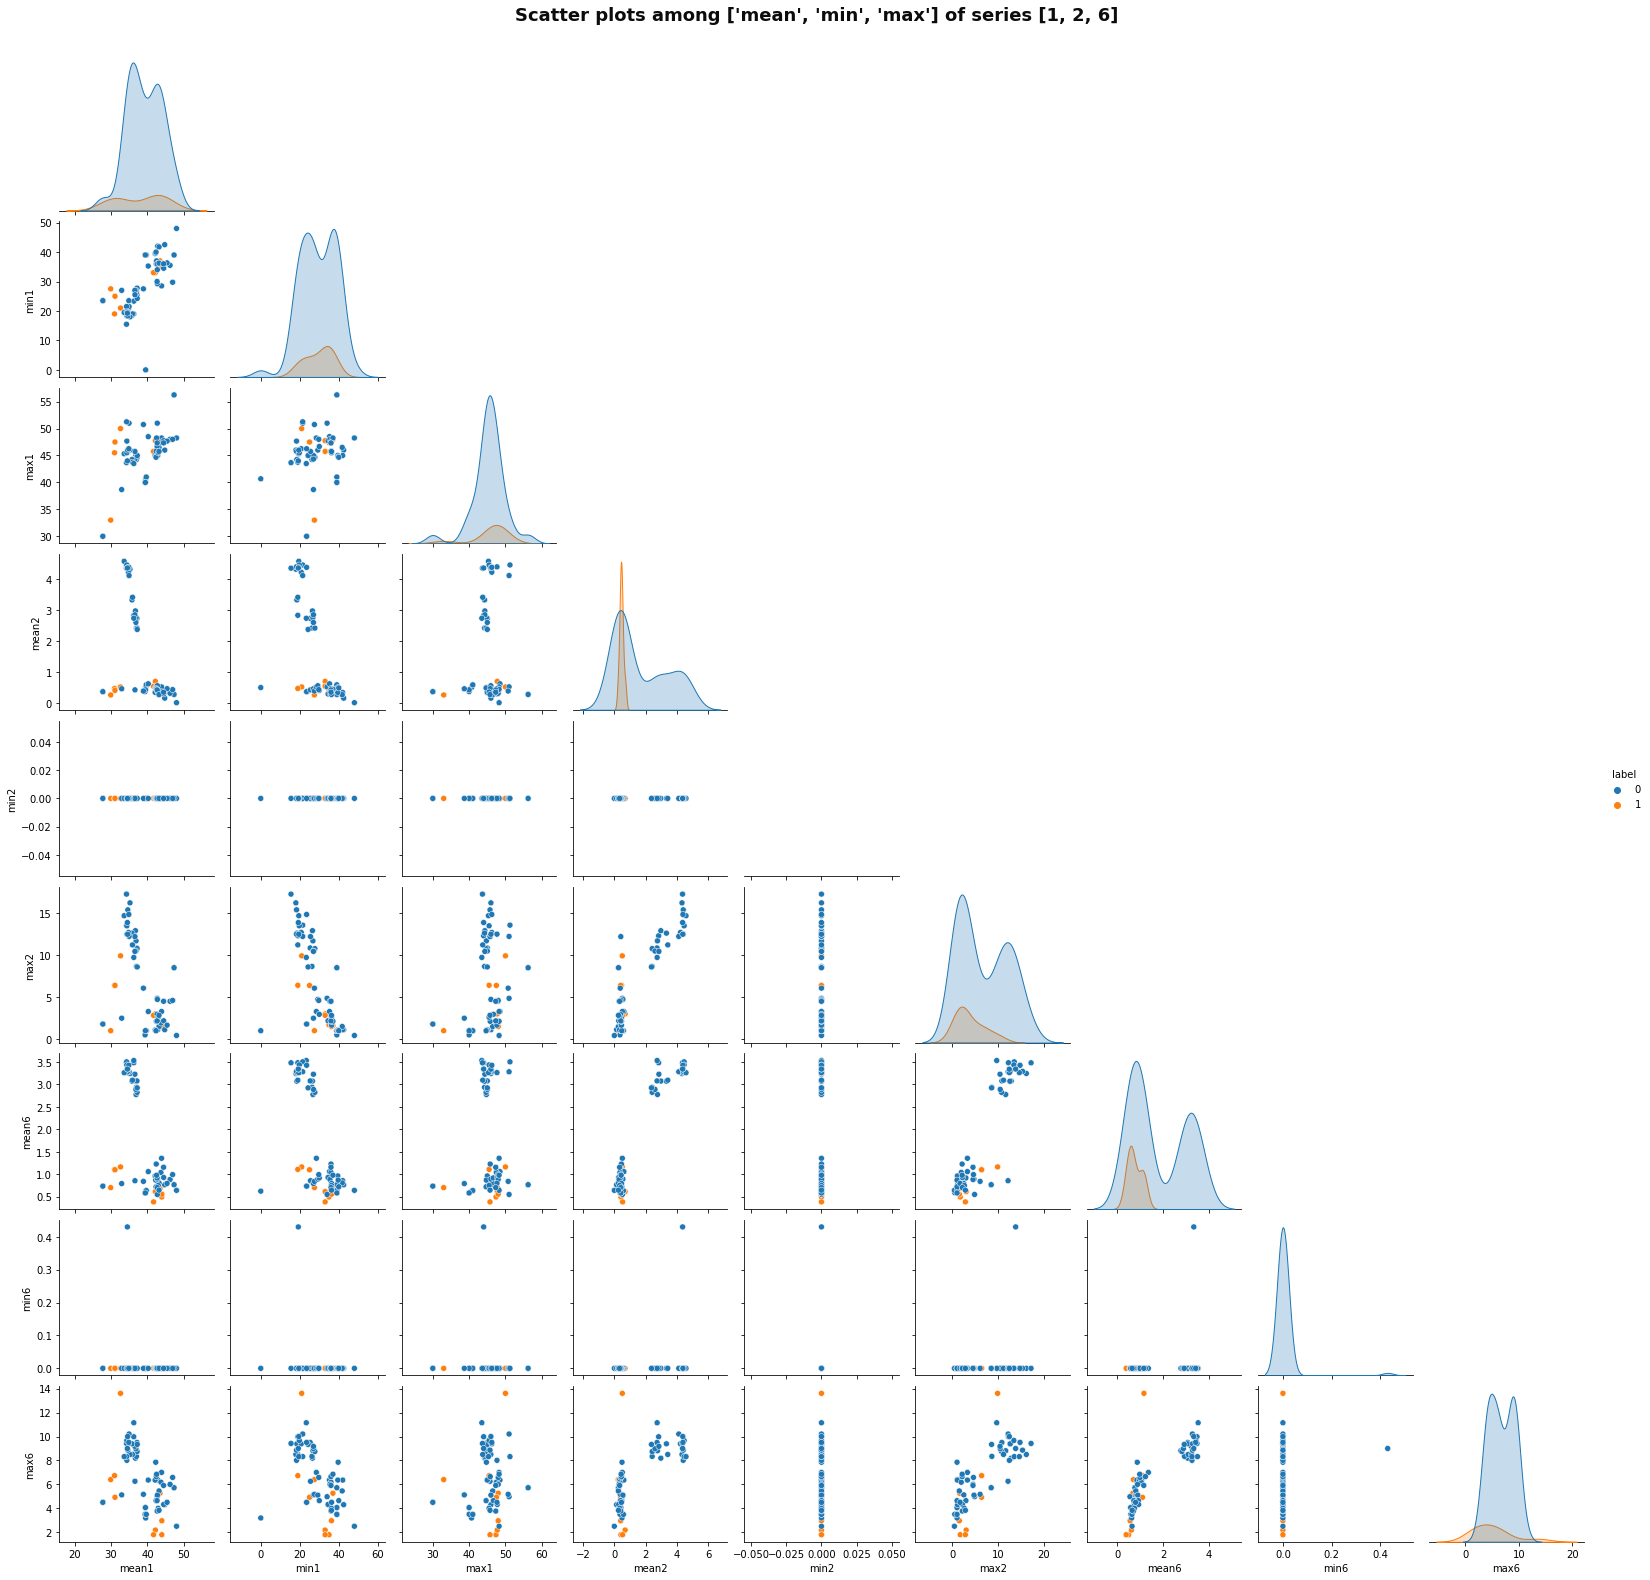

In [8]:
sub_features = ["mean", "min", "max"]
series_number = [1, 2, 6]
f = scatterplot_sub(sub_features, series_number,
                    TDF_df.iloc[train_index, :], binary_train_label)

4.Time Series Classification Part 2: Binary and Multiclass Classification
(a) Binary Classification Using Logistic Regression
i. Break each time series in your training set into two (approximately) equal length time series.

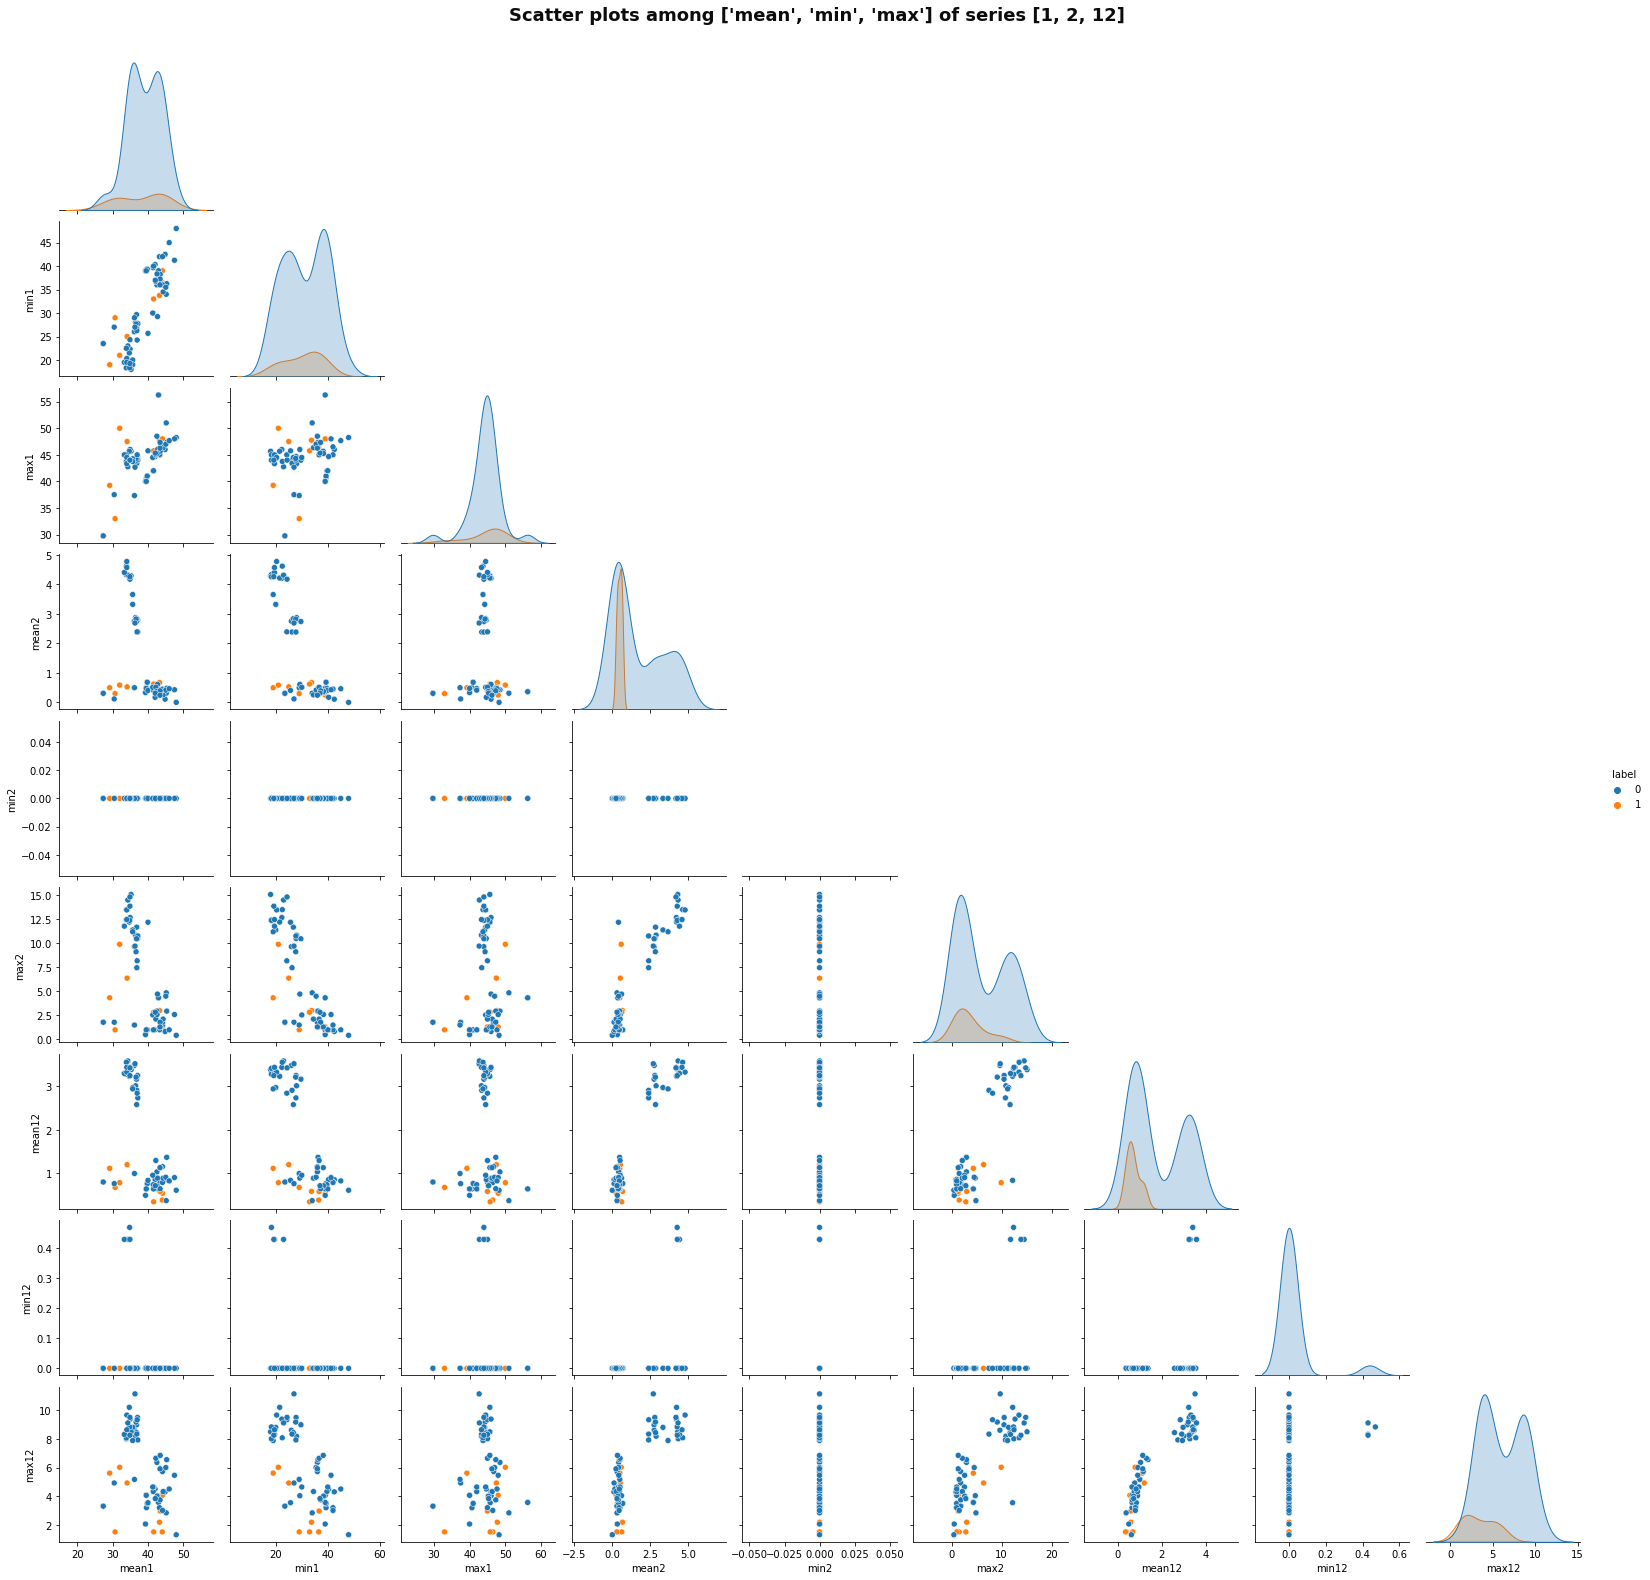

In [9]:
TDF_df2 = extract_features(data_list, 2)

sub_features = ["mean", "min", "max"]
series_number = [1, 2, 12]
f2 = scatterplot_sub(sub_features, series_number,
                    TDF_df2.iloc[train_index, :], binary_train_label)

No, I didn't see any considerable differences.

ii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features.

As for the wrong way :

for l ∈ {1, 2, . . . , 20}

    (1)Use sklearn.feature_seletion to find a subset of "best" p predictors

    (2)Use these p predictors to build a logistic regression model

    (3)Apply cross-validation to estimate unknown parameters and to estimate the predication error of the model with l broken time series

    (4)choose the pair (l, p)which has the smallest CV error.

As for the right way :

for l ∈ {1, 2, . . . , 20}

    for p ∈ {1, 2, . . . , 6*l}

        for k fold ∈ {1, 2, 3, 4, 5}

             (1)Use sklearn.feature_seletion to find a subset of "best" p predictors based on other k-1 folds

             (2)Use the k folds to calculate the error rate

        (3)Average the k error rates
        
(4)choose the pair (l, p) which has the smallest average error rate.




In [10]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import numpy as np

# prepare data
TDF_df_list = [] 
# store all data frames with different number of broken time series

for l in range(1, 21):
    TDF_df_list.append(extract_features(data_list, l))

In [11]:
y = np.array(binary_train_label)
rfecv_list = [] # store all rfecv objects
l = 1
for df in TDF_df_list: 
    X = df.iloc[train_index, :]
    model = LogisticRegression(C=10000, solver='liblinear' ,max_iter=50)
    # C->infinite, lamda->0 and using other solvers takes too much time
    cv = StratifiedKFold(5, shuffle=True, random_state=12)
    rfecv = RFECV(estimator=model, cv=cv, scoring="accuracy")
    rfecv.fit(X, y)
    rfecv_list.append(rfecv)
    l += 1

In [12]:
scores = [] # store max cv scores
lp_pairs = [] # store best pairs of l and p
l = 1
for rfecv in rfecv_list:
    scores.append(np.max(rfecv.cv_results_['mean_test_score']))
    lp_pairs.append((l, rfecv.n_features_))
    l += 1
print("the best pair of l and p is", lp_pairs[np.argmax(scores)])

the best pair of l and p is (1, 6)


iii. Report the confusion matrix and show the ROC and AUC for your classifier on train data.

In [13]:
def plot_roc(y_true, y_score, name=None):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    area = auc(fpr, tpr)
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % area,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name+" Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

def plot_cm(y_true, y_pred, labels):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

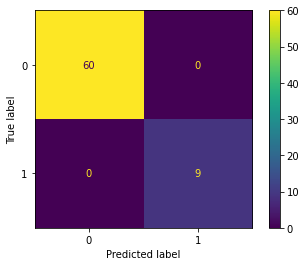

In [14]:
max_i = np.argmax(scores) # index of max score
l, p = lp_pairs[max_i]
lr_classifer = LogisticRegression(C=10000,solver='liblinear' ,max_iter=50)
# C->infinite, lamda->0 and using other solvers takes too much time
rfe_final = RFE(estimator=lr_classifer, n_features_to_select=p)
X_train = TDF_df_list[max_i].iloc[train_index, :]
y_train = np.array(binary_train_label)
rfe_final.fit(X_train, y_train)
y_pred_train = rfe_final.predict(X_train)

plot_cm(y_train, y_pred_train, [0, 1])

In [15]:
print("beta coeffcients are:")
res = [rfe_final.estimator_.intercept_[0]]
res = res + list(rfe_final.estimator_.coef_[0])
print(res)

beta coeffcients are:
[-0.06531835005098421, -2.2160785194669956, 0.8148631017901656, 1.1952153066514528, 0.9416234188492439, 1.958875843367916, -1.2482022215849629]


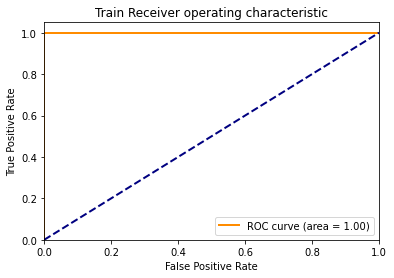

In [16]:
y_scores = rfe_final.predict_proba(X_train)[:, 1]
plot_roc(y_train, y_scores, name="Train")

iv.Test the classifier on the test set.

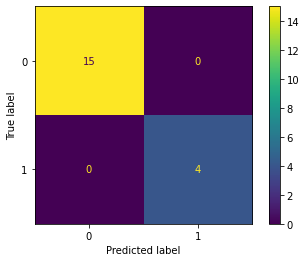

In [17]:
X_test = TDF_df_list[max_i].iloc[test_index, :]
y_test = np.array(binary_test_label)
y_pred_test = rfe_final.predict(X_test)

plot_cm(y_test, y_pred_test, [0, 1])

Cross validation accuracy : 100%

Test accuracy : 100%

v.Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

In [18]:
import statsmodels.api as sm
try:
    X_train = TDF_df_list[max_i].iloc[train_index, :].iloc[:, rfe_final.support_]
    X_train = sm.add_constant(X_train)
    y_train = np.array(binary_train_label)
    logit_model=sm.Logit(y_train, X_train)
    result=logit_model.fit()
except Exception as e:
    print(e)

Perfect separation detected, results not available


Yes, my classes seem to be well-seperated and I can't get a unreasonable p value.

vi.From the confusion matrices you obtained, do you see imbalanced classes?

Yes, I can see imbalanced class

In [19]:
X_train = TDF_df_list[max_i].iloc[train_index, :]
y_train = np.array(binary_train_label)

print("Original data : ", Counter(y_train))
sm = SMOTE(sampling_strategy={0:60, 1:30},random_state=42, k_neighbors=3)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After adding new data for minority : ", Counter(y_train_sm))

Original data :  Counter({0: 60, 1: 9})
After adding new data for minority :  Counter({0: 60, 1: 30})


Confusion matrix of training data after sampling:


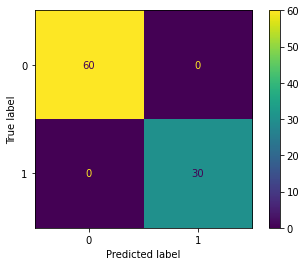

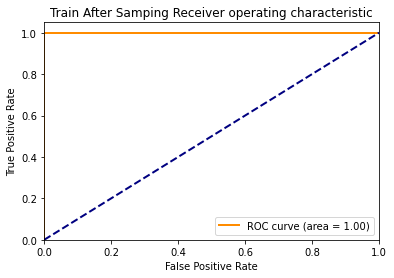

In [20]:
lr_classifer = LogisticRegression(C=10000,solver='liblinear' ,max_iter=50)
rfe_sm = RFE(estimator=lr_classifer, n_features_to_select=p)
rfe_sm.fit(X_train_sm, y_train_sm)
y_pred_train_sm = rfe_sm.predict(X_train_sm)

print("Confusion matrix of training data after sampling:")
plot_cm(y_train_sm, y_pred_train_sm, [0, 1])
y_scores_sm = rfe_sm.predict_proba(X_train_sm)[:, 1]
plot_roc(y_train_sm, y_scores_sm, name="Train After Samping")

Confusion matrix of original training data after correcting intercept:


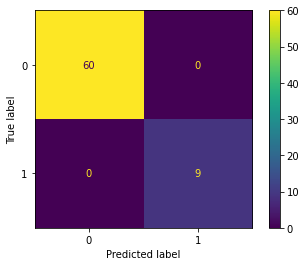

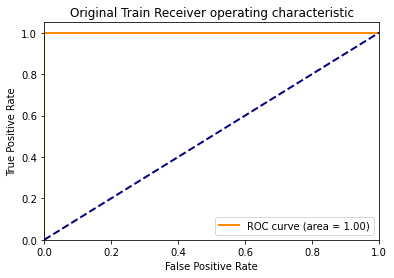

In [21]:
true_positive_fration = np.count_nonzero(y_train)/len(y_train)
balanced_positive_fration = np.count_nonzero(y_train_sm)/len(y_train_sm)

rfe_sm.estimator_.intercept_ = rfe_sm.estimator_.intercept_ + \
    np.log(true_positive_fration/(1-true_positive_fration)) \
    - np.log(balanced_positive_fration/(1-balanced_positive_fration))

y_pred_train = rfe_sm.predict(X_train)
print("Confusion matrix of original training data after correcting intercept:")
plot_cm(y_train, y_pred_train, [0, 1])
y_scores = rfe_sm.predict_proba(X_train)[:, 1]
plot_roc(y_train, y_scores, name="Original Train")

Confusion matrix of test data after correcting intercept:


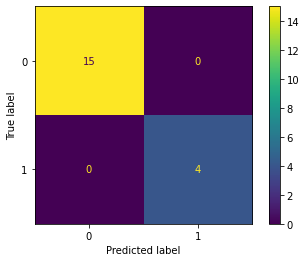

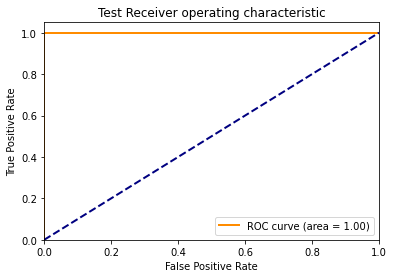

In [22]:
y_pred_test = rfe_sm.predict(X_test)
print("Confusion matrix of test data after correcting intercept:")
plot_cm(y_test, y_pred_test, [0, 1])
y_scores = rfe_sm.predict_proba(X_test)[:, 1]
plot_roc(y_test, y_scores, name="Test")

(b) Binary Classification Using L1-penalized logistic regression

i.Repeat 4(a)ii using L1-penalized logistic regression

In [23]:
y = np.array(binary_train_label) 
pipe_list = [] # store all Scaler and LogisticRegressionCV pipeline objects
l = 1
for df in TDF_df_list: 
    X = df.iloc[train_index, :]
    cv = StratifiedKFold(5, shuffle=True, random_state=12)
    model = LogisticRegressionCV(Cs=50, penalty='l1', solver='liblinear', cv=cv,
                             max_iter=50, scoring="accuracy")
    pipe = Pipeline([('s', StandardScaler()), ('m', model)])
    pipe.fit(X, y)
    pipe_list.append(pipe)
    l += 1

In [24]:
scores_L1 = [] # store max cv scores
lC_pairs = [] # store best pairs of l and C
l = 1
for pipe in pipe_list:
    scores_L1.append(np.max(pipe['m'].scores_[1].mean(axis=0)))
    lC_pairs.append((l, pipe['m'].C_[0]))
    l += 1
print("the best pair of l and C is", lC_pairs[np.argmax(scores)])

the best pair of l and C is (1, 0.3906939937054613)


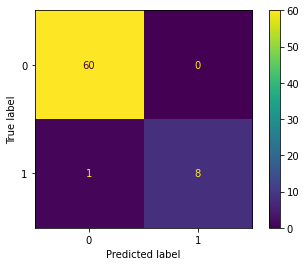

In [25]:
max_i = np.argmax(scores) # index of max score
l, C = lC_pairs[max_i] 

model = LogisticRegression(C=C, penalty='l1', solver='liblinear',
                             max_iter=50)
pipe_final = Pipeline([('s', StandardScaler()), ('m', model)])
X_train = TDF_df_list[max_i].iloc[train_index, :]
y_train = np.array(binary_train_label)
pipe_final.fit(X_train, y_train)
y_pred_train = pipe_final.predict(X_train)

plot_cm(y_train, y_pred_train, [0, 1])

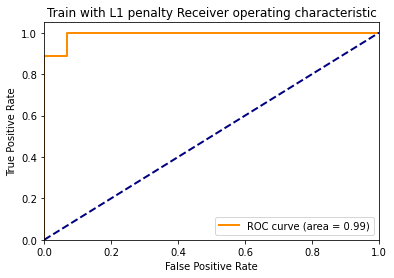

In [26]:
y_scores = pipe_final.predict_proba(X_train)[:, 1]
plot_roc(y_train, y_scores, name="Train with L1 penalty")

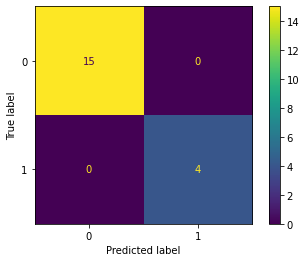

In [27]:
X_test = TDF_df_list[max_i].iloc[test_index, :]
y_test = np.array(binary_test_label)
y_pred_test = pipe_final.predict(X_test)

plot_cm(y_test, y_pred_test, [0, 1])

ii. Compare the L1-penalized with variable selection using p-values.

In order to improve the operating efficiency, the L1-penalized method sacrifices a certain amount of bais, and the deviation of the training set will increase. But we still get the same effect on the test set, only from this point, the L1-penalized method is better.

(c) Multi-class Classification
i.Find the best l in the same way as you found it in 4(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.

In [64]:
def plot_multi_roc(y, y_score, name=None):
    
    classes = pipe_final_ml.classes_
    n_classes = len(classes)
    enc = OneHotEncoder()
    enc.fit(classes.reshape(-1, 1))
    y_true = enc.transform(y.reshape(-1, 1)).toarray()
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    lw = 2
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = ["aqua", "darkorange", "cornflowerblue",
            "firebrick", "orange", "deeppink"]
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name + "Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
y = np.array(multi_train_label)
pipe_list = []  # store all Scaler and LogisticRegressionCV pipeline objects
l = 1
for df in TDF_df_list:
    X = df.iloc[train_index, :]
    cv = StratifiedKFold(5, shuffle=True, random_state=12)
    model = LogisticRegressionCV(Cs=50, penalty='l1', solver='saga', cv=cv,
                                 max_iter=300, scoring="accuracy",
                                 multi_class='multinomial', n_jobs=2)
    pipe = Pipeline([('s', StandardScaler()), ('m', model)])
    pipe.fit(X, y)
    pipe_list.append(pipe)
    l += 1

In [30]:
scores_L1_multiclass = [] # store max cv scores
lC_pairs = [] # store best pairs of l and C
l = 1
for pipe in pipe_list:
    scores_L1_multiclass.append(np.max(pipe['m'].scores_['bending'].mean(axis=0)))
    lC_pairs.append((l, pipe['m'].C_[0]))
    l += 1
print("the best pair of l and C is", lC_pairs[np.argmax(scores)])

the best pair of l and C is (1, 0.2682695795279725)


Confusion Matrix of train multiclass data:


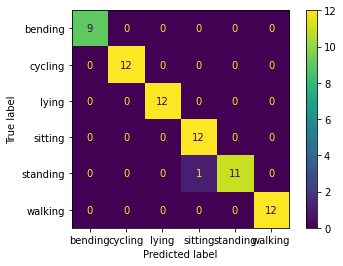

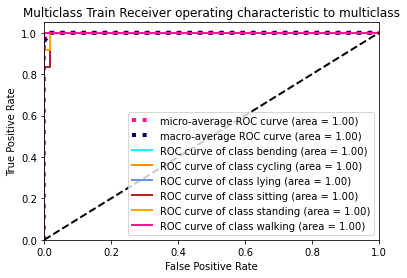

In [65]:
max_i = np.argmax(scores_L1_multiclass) # index of max score
l, C = lC_pairs[max_i] 

model = LogisticRegression(penalty='l1', solver='saga',
                                 max_iter=300, multi_class='multinomial', n_jobs=2)
pipe_final_ml = Pipeline([('s', StandardScaler()), ('m', model)])
X_train_ml = TDF_df_list[max_i].iloc[train_index, :]
y_train_ml = np.array(multi_train_label)
pipe_final_ml.fit(X_train_ml, y_train_ml)
y_pred_train_ml = pipe_final_ml.predict(X_train_ml)
y_score_train_ml = pipe_final_ml.predict_proba(X_train_ml)

print("Confusion Matrix of train multiclass data:")
plot_cm(y_train_ml, y_pred_train_ml, pipe_final_ml['m'].classes_)
plot_multi_roc(y_train_ml, y_score_train_ml, name="Multiclass Train ")

Multinomial LR test error is 10.53%
Confusion Matrix of test multiclass data:


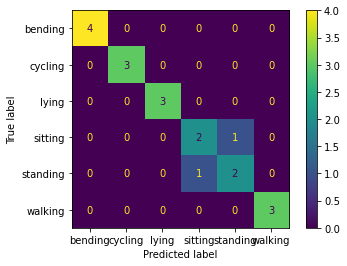

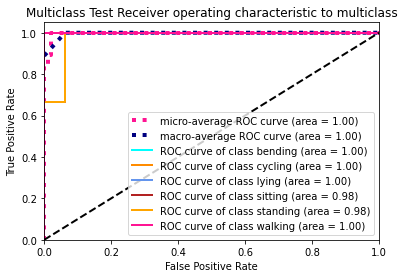

In [79]:
X_test = TDF_df_list[max_i].iloc[test_index, :]
y_test = np.array(multi_test_label)
y_pred_test = pipe_final_ml.predict(X_test)
y_score_test = pipe_final_ml.predict_proba(X_test)

test_error = 1 - pipe_final_ml.score(X_test, y_test)
print(f"Multinomial LR test error is {test_error*100:.2f}%")
print("Confusion Matrix of test multiclass data:")
plot_cm(y_test, y_pred_test, pipe_final_ml['m'].classes_)
plot_multi_roc(y_test, y_score_test, name="Multiclass Test ")


ii.Repeat 4(c)i using a Naive Bayes’ classifier.

In [72]:
# Gaussian Naive Bayes
y = np.array(multi_train_label)
gnb_score_list = []
for df in TDF_df_list:
    X = df.iloc[train_index, :]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    gnb = GaussianNB()
    scores = cross_val_score(gnb, X, y, scoring='accuracy', cv=cv)
    gnb_score_list.append(np.mean(scores))

Confusion Matrix of GNB train data:


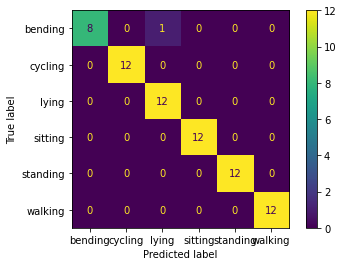

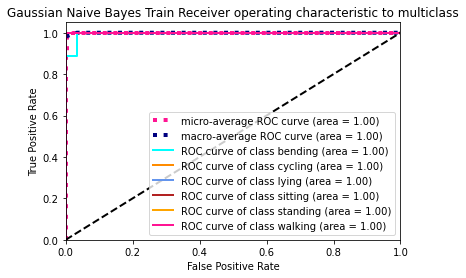

In [90]:
max_i = np.argmax(gnb_score_list)
X_train_gnb = TDF_df_list[max_i].iloc[train_index, :]
y_train_gnb = np.array(multi_train_label)
gnb_final = GaussianNB().fit(X_train_gnb, y_train_gnb)

y_pred_train_gnb = gnb_final.predict(X_train_gnb)
y_score_train_gnb = gnb_final.predict_proba(X_train_gnb)

print("Confusion Matrix of GNB train data:")
plot_cm(y_train_gnb, y_pred_train_gnb, gnb_final.classes_)
plot_multi_roc(y_train_gnb, y_score_train_gnb, name="Gaussian Naive Bayes Train ")

GNB test error is 10.53%
Confusion Matrix of GNB test data:


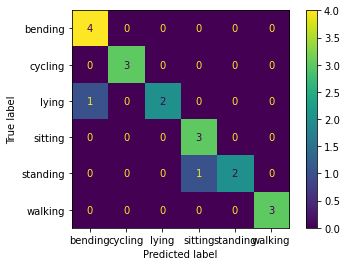

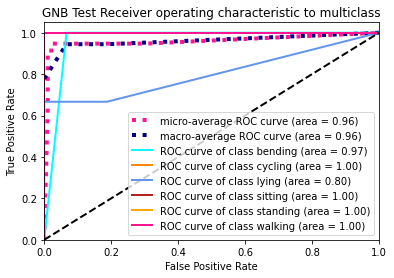

In [80]:
X_test = TDF_df_list[max_i].iloc[test_index, :]
y_test = np.array(multi_test_label)
y_pred_test = gnb_final.predict(X_test)
y_score_test = gnb_final.predict_proba(X_test)

test_error = 1 - gnb_final.score(X_test, y_test)
print(f"GNB test error is {test_error*100:.2f}%")
print("Confusion Matrix of GNB test data:")
plot_cm(y_test, y_pred_test, gnb_final.classes_)
plot_multi_roc(y_test, y_score_test, name="GNB Test ")

In [86]:
# multinomial naive bayes
y = np.array(multi_train_label)
mnb_score_list = []
for df in TDF_df_list:
    X = df.iloc[train_index, :]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    mnb = MultinomialNB()
    scores = cross_val_score(mnb, X, y, scoring='accuracy', cv=cv)
    mnb_score_list.append(np.mean(scores))

Confusion Matrix of MNB train data:


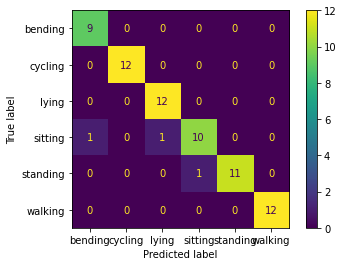

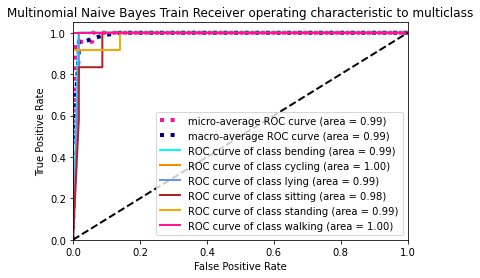

In [89]:
max_i = np.argmax(mnb_score_list)
X_train_mnb = TDF_df_list[max_i].iloc[train_index, :]
y_train_mnb = np.array(multi_train_label)
mnb_final = MultinomialNB().fit(X_train_mnb, y_train_mnb)

y_pred_train_mnb = mnb_final.predict(X_train_mnb)
y_score_train_mnb = mnb_final.predict_proba(X_train_mnb)

print("Confusion Matrix of MNB train data:")
plot_cm(y_train_mnb, y_pred_train_mnb, mnb_final.classes_)
plot_multi_roc(y_train_mnb, y_score_train_mnb, name="Multinomial Naive Bayes Train ")

mnb test error is 10.53%
Confusion Matrix of mnb test data:


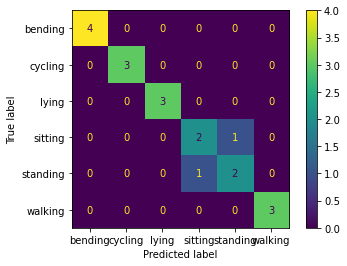

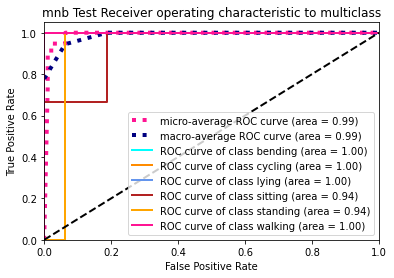

In [88]:
X_test = TDF_df_list[max_i].iloc[test_index, :]
y_test = np.array(multi_test_label)
y_pred_test = mnb_final.predict(X_test)
y_score_test = mnb_final.predict_proba(X_test)

test_error = 1 - mnb_final.score(X_test, y_test)
print(f"mnb test error is {test_error*100:.2f}%")
print("Confusion Matrix of mnb test data:")
plot_cm(y_test, y_pred_test, mnb_final.classes_)
plot_multi_roc(y_test, y_score_test, name="mnb Test ")

We both get the same results on the test data, but on the train data set, Gaussian Naive Bayes get a better results.

iii.Create p Principal Components from features extracted from features you extracted from l time series

In [122]:
# Gaussian Naive Bayes with PCA
y = np.array(multi_train_label)
gnb_pca_list = []
ln_pairs = []
gnb_pca_score_list = []
for df in TDF_df_list:
    X = df.iloc[train_index, :]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    best_n = 1
    max_score = 0
    for n in range(1, min(X.shape)):
        gnb_pca = Pipeline([('pca', PCA(n_components=n)), ('m', GaussianNB())])
        scores = cross_val_score(gnb_pca, X, y, scoring='accuracy', cv=cv)
        if(np.mean(scores) > max_score):
            max_score = np.mean(scores)
            best_n = n

    gnb_pca_list.append(gnb_pca)
    gnb_pca_score_list.append(max_score)
    ln_pairs.append((l, best_n))

In [127]:
max_i = np.argmax(gnb_pca_score_list)
print("best pair of l and n_components is", ln_pairs[max_i])
l, n = ln_pairs[max_i]
X_train_gnb_pca = TDF_df_list[max_i].iloc[train_index, :]
y_train_gnb_pca = np.array(multi_train_label)

gnb_pca_final = Pipeline([('pca', PCA(n_components=n)), ('m', GaussianNB())])
gnb_pca_final.fit(X_train_gnb_pca, y_train_gnb_pca)

best pair of l and n_components is (1, 5)


Pipeline(steps=[('pca', PCA(n_components=5)), ('m', GaussianNB())])

Confusion Matrix of gnb_pca train data:


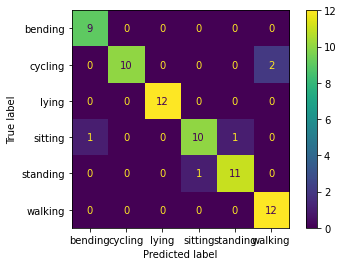

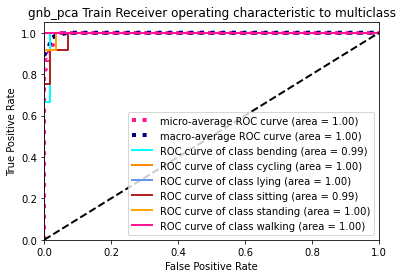

gnb_pca test error is 0.00%
Confusion Matrix of gnb_pca test data:


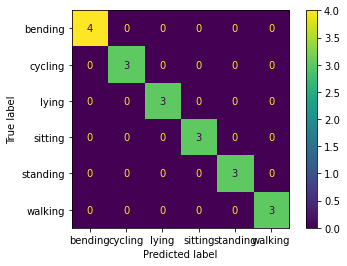

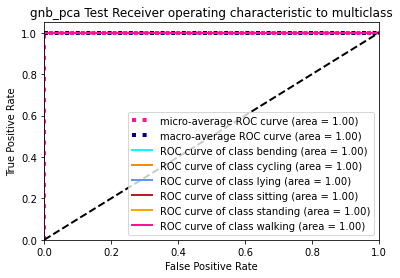

In [129]:
y_pred_train_gnb_pca = gnb_pca_final.predict(X_train_gnb_pca)
y_score_train_gnb_pca = gnb_pca_final.predict_proba(X_train_gnb_pca)

print("Confusion Matrix of gnb_pca train data:")
plot_cm(y_train_gnb_pca, y_pred_train_gnb_pca, gnb_pca_final.classes_)
plot_multi_roc(y_train_gnb_pca, y_score_train_gnb_pca, name="gnb_pca Train ")

X_test = TDF_df_list[max_i].iloc[test_index, :]
y_test = np.array(multi_test_label)
y_pred_test = gnb_pca_final.predict(X_test)
y_score_test = gnb_pca_final.predict_proba(X_test)

test_error = 1 - gnb_pca_final.score(X_test, y_test)
print(f"gnb_pca test error is {test_error*100:.2f}%")
print("Confusion Matrix of gnb_pca test data:")
plot_cm(y_test, y_pred_test, gnb_pca_final.classes_)
plot_multi_roc(y_test, y_score_test, name="gnb_pca Test ")

iv. Which method is better for multi-class classification in this problem?

From test accuracy, we get 100% accuracy by using Gaussian Naive Bayes with PCA decomposition, therefore gnb with pca is the best method in this problem.

References: https://zhuanlan.zhihu.com/p/144193861
https://blog.csdn.net/qq_52300431/article/details/123482513
https://zhuanlan.zhihu.com/p/109493687